# Multi-Factor Equity Strategy

Designing a trading strategy that:

- Uses multi-factor signals (momentum, volatility).

- Applies a Gaussian Mixture Model (GMM) to detect market regimes (bull, bear, sideways).

- Allocates portfolio weights using risk-parity optimization or minimum-variance allocation.




        Historical Prices / Returns
                   │
                   ▼
      ┌───────────────────────────┐
      │ Compute Factor Signals    │
      │ (Momentum, Volatility,    │
      │  Value, etc.)             │
      └───────────────────────────┘
                   │
                   ▼
      ┌───────────────────────────┐
      │ Standardize Factors       │
      │ - Time-series (columns)   │
      │ - Cross-sectional (rows)  │
      └───────────────────────────┘
                   │
                   ▼
      ┌───────────────────────────┐
      │ Composite Alpha Signal    │
      │ - Average of standardized │
      │   factors (with signs)    │
      └───────────────────────────┘
                   │
                   ▼
      ┌───────────────────────────┐
      │ Scale Signal to Match     │
      │ Expected Return Units     │
      └───────────────────────────┘
                   │
                   ▼
      ┌────────────────────────────────┐
      │ Portfolio Optimizer            │
      │ Objective: maximize            │
      │ wᵀ * (α + μ_baseline) - λ wᵀΣw │
      │ Constraints: long-only,        │
      │ fully invested, sector/turnover│
      └────────────────────────────────┘
                   │
                   ▼
        Optimized Portfolio Weights


## Libraries


In [153]:
!pip install hmmlearn --quiet

In [154]:
import numpy as np
import cvxpy as cp
import pandas as pd
import sklearn as sk
import yfinance as yf
import seaborn as sns
from hmmlearn import hmm
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from warnings import filterwarnings
filterwarnings('ignore')

# Changing the plot theme
sns.set_theme()

# Setting the plot style
sns.set_style("ticks")

## Functions

### Data

In [155]:
# Downloading data from Yahoo Finance and taking the closing prices only
def get_price_data(tickers, start_date, end_date):
  data = yf.download(tickers, start = start_date, end = end_date, auto_adjust = True)
  return data['Close']

def get_eps_data(tickers):
    eps_data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        eps = stock.earnings_dates
        eps['Ticker'] = ticker
        eps_data = pd.concat([eps_data, eps], axis=0)
    return eps_data

def plot_regime_hmm(hmm_signals_sp500, sorted_means_indices_hmm):
  fig = go.Figure()


  fig.update_layout(
      template="plotly_white",
      font_size=14,

      title_text="S&P 500 Value by HMM Regime",
      title_font_size=40,
      title_x=0.5,

      xaxis_title="Date",
      yaxis_title="S&P 500 Value",
      xaxis=dict(showgrid=False,),
      yaxis=dict(showgrid=False),

      font=dict(family="Open Sans", size=14),

      legend=dict(
          orientation="h",
          yanchor="bottom",
          y=1.02,
          xanchor="right",
          x=1
      ),

      height=600,
      width=1200
  )


  color_index = 0
  colors = ["#e41a1c", "#377eb8", "#4daf4a"]

  for i in sorted_means_indices_hmm:
      group_df_hmm = hmm_signals_sp500[hmm_signals_sp500['Group'] == i]
      fig.add_trace(go.Scatter(
          x=group_df_hmm.index,
          y=group_df_hmm['SP500'],
          mode='markers',
          name=f'Regime {i}',
          marker=dict(
              color=colors[color_index],
              size = 4
              )
          ))
      color_index += 1

  fig.show()

### CVXPY Portfolio Construction

#### Factor Portfolio Optimization: Mathematical Formulation

##### Objective Function
$$\max_{w} \quad w^T \cdot (\alpha + \mu) - \lambda \cdot w^T \Sigma w$$
where
$$ \alpha = \sum_{f=1}^{F} \alpha_f $$

| Symbol | Definition |
|--------|------------|
| $w$ | Portfolio weights vector $[w_1, ..., w_n]^T$ |
| $\mu$ | Expected returns vector |
| $\Sigma$ | Covariance matrix ($n \times n$) |
| $\lambda$ | Risk aversion parameter |
| $\alpha_f$ | cross-standardized factor $f$ |

In [156]:
def cvx_optimize_factor_portfolio(factor_scores, covariance_matrix, expected_returns, risk_tolerance, state, print_parameters = False):

    if state == "Bull":
        risk_tolerance *= 0.1
    elif state == "Bear":
        risk_tolerance *=1.2

    if print_parameters:
        print("Building Porfolio using: ")
        print("\nFactor Scores: \n",factor_scores)
        print("\nCovariance Matrix: \n",covariance_matrix)
        print("\nExpected Returns: \n",expected_returns)
        print("\nRisk Tolerance: ",risk_tolerance)
        print("\nBuilding...\n\n")

    number_of_stocks = covariance_matrix.shape[0]
    x = cp.Variable(number_of_stocks)

    sigma = cp.Parameter((number_of_stocks, number_of_stocks), PSD=True)
    sigma.value = covariance_matrix

    portfolio_variance = cp.quad_form(x, sigma)

    return_with_factor = expected_returns + factor_scores * 0.0001


    objective = x.T * return_with_factor - risk_tolerance * portfolio_variance

    constraints = [
        cp.sum(x) == 1,
        x >= 0
    ]


    problem = cp.Problem(cp.Maximize(objective), constraints)

    problem.solve()


    return x

### Factors

In [157]:
def momentum_12_1(price_df):

    price_12m = price_df.shift(252)
    price_1m= price_df.shift(21)

    momentum = (price_1m - price_12m) / price_12m

    return momentum

def rolling_percentile_rank(factor_df, window_size):

    ranked_df = factor_df.rolling(window=window_size).rank(pct=True)

    return ranked_df

def standardize_factor_data(factor_df, window_size):
    """
    Standardize the factor data using the rolling (based on the window size) mean and standard deviation.
    """
    rolling_mean = factor_df.rolling(window=window_size, min_periods=window_size).mean()
    rolling_std = factor_df.rolling(window=window_size, min_periods=window_size).std()

    standardized_factor_df = (factor_df - rolling_mean) / rolling_std

    return standardized_factor_df

def cross_standardize(factor_df):
    cs_mean = factor_df.mean(axis=1)
    cs_std = factor_df.std(axis=1)

    cs_zscore = (factor_df.sub(cs_mean, axis=0)).div(cs_std, axis=0)

    return  cs_zscore


## Data Exploration

In [158]:
# Tickers can be customized to whatever stock you want to look at
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', '^GSPC','GS','MP','VZ','WMT','COST','UNH']
macroTickers = ['^GSPC']
end_date =  pd.Timestamp.today() - pd.DateOffset(months = 12)
start_date = end_date - pd.DateOffset(years = 4)

price_data = get_price_data(tickers, start_date, end_date)
macro_data = get_price_data(macroTickers, start_date, end_date)

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


In [159]:
price_data

Ticker,AAPL,AMZN,COST,GOOG,GS,META,MP,MSFT,UNH,VZ,WMT,^GSPC
Date,,,,,,,,,,,,
2020-12-11,119.160294,155.820999,354.910339,88.425293,213.111145,271.873932,26.430000,204.631439,310.690094,44.726727,45.874207,3663.459961
2020-12-14,118.547005,157.848495,354.229095,87.347878,211.157516,272.510040,26.299999,205.533447,309.823639,44.452515,45.452923,3647.489990
2020-12-15,124.485077,158.255997,351.863617,87.730507,215.277863,273.861694,25.680000,205.466248,313.086670,44.874954,45.431080,3694.620117
2020-12-16,124.416931,162.048004,349.555023,87.493782,216.467773,273.980988,28.230000,210.407883,312.782471,44.400639,45.384262,3701.169922
2020-12-17,125.283310,161.804001,350.359314,86.744400,217.053864,272.798309,32.619999,210.542236,314.930115,44.474747,45.593357,3722.479980
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04,241.915878,218.160004,985.776062,175.208344,586.735779,611.856140,21.129999,434.216858,593.832153,39.781113,93.537956,6086.490234
2024-12-05,241.945709,220.550003,977.161072,173.437256,584.863953,607.021301,20.010000,439.378815,562.895508,39.809174,94.379753,6075.109863
2024-12-06,241.746628,227.029999,987.457275,175.606354,587.686401,621.814819,19.719999,440.321869,534.360474,39.640770,94.775887,6090.270020


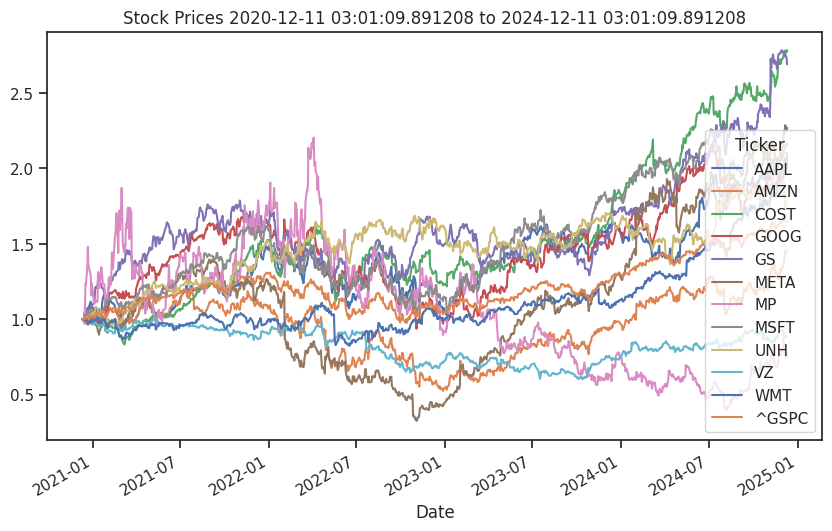

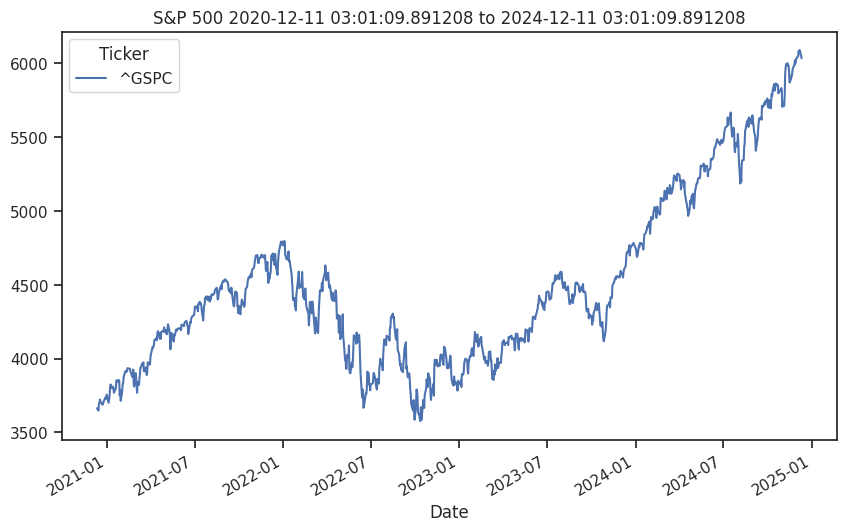

In [160]:
# Divide the data by their first price so they all begin at 1
normalized_price_data = price_data/price_data.iloc[0]
normalized_price_data.plot(figsize = (10,6), title = f'Stock Prices {start_date} to {end_date}')

plt.show()

macro_data.plot(figsize = (10,6), title = f'S&P 500 {start_date} to {end_date}')
plt.show()

## Market Regime

We will use a Gaussian Mixture Model (GMM) to classify the market regimes for our model. Here, GMM performs the task of clustering, placing the market intos three different groups (regimes).

In [161]:
macro_data.columns = ['SP500']
returns_sp500 = np.log(macro_data['SP500']/macro_data['SP500'].shift(1)).dropna()

hmm_model = hmm.GaussianHMM(n_components=3)
hmm_model.fit(returns_sp500.values.reshape(-1, 1))
hmm_groups = hmm_model.predict(returns_sp500.values.reshape(-1, 1))

hmm_signals_sp500 = pd.concat([macro_data['SP500'], pd.DataFrame(hmm_groups, index = returns_sp500.index), returns_sp500], axis=1)
hmm_signals_sp500.columns = ['SP500', 'Group', 'Returns']

hmm_signals_sp500.dropna(inplace=True)
display(hmm_signals_sp500.head())
display(hmm_signals_sp500.tail())

,SP500,Group,Returns
Date,,,
2020-12-14,3647.489990,2.0,-0.004369
2020-12-15,3694.620117,2.0,0.012838
2020-12-16,3701.169922,2.0,0.001771
2020-12-17,3722.479980,2.0,0.005741
2020-12-18,3709.409912,2.0,-0.003517


,SP500,Group,Returns
Date,,,
2024-12-04,6086.490234,2.0,0.006033
2024-12-05,6075.109863,2.0,-0.001872
2024-12-06,6090.270020,2.0,0.002492
2024-12-09,6052.850098,2.0,-0.006163
2024-12-10,6034.910156,2.0,-0.002968


[[-0.00101431]
 [ 0.02660775]
 [ 0.00085135]]
[0 2 1] 

Group: 0
Regime: Bear
Mean: [-0.00101431]
Covariances (Σ): [[0.00028843]]

Group: 2
Regime: Neutral
Mean: [0.00085135]
Covariances (Σ): [[7.9475978e-05]]

Group: 1
Regime: Bull
Mean: [0.02660775]
Covariances (Σ): [[0.00706186]]


 Probability Transition Matrix:


array([[0.992, 0.006, 0.002],
       [0.105, 0.023, 0.872],
       [0.002, 0.   , 0.998]])

[]

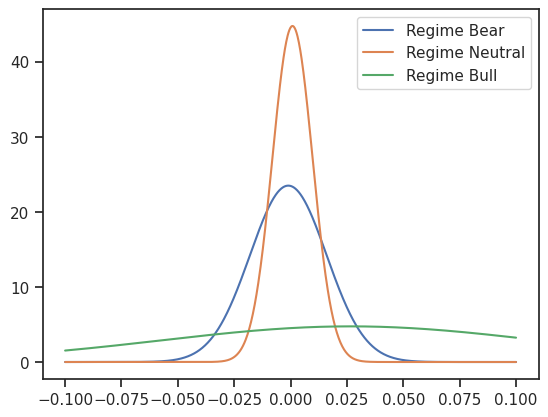

In [162]:
print(hmm_model.means_)
print(np.argsort(hmm_model.means_.flatten()),"\n")

sorted_means_indices_hmm = np.argsort(hmm_model.means_.flatten(),)
state_space = ["Bear", "Neutral", "Bull"]

x = np.linspace(-0.1, 0.1, 1000)

for regime, state in zip(sorted_means_indices_hmm, state_space):
    print(f"Group: {regime}")
    print(f"Regime: {state}")
    print(f"Mean: {hmm_model.means_[regime]}")
    print(f"Covariances (Σ): {hmm_model.covars_[regime]}\n")

    y = norm.pdf(x, hmm_model.means_[regime][0], np.sqrt(hmm_model.covars_[regime][0]))
    plt.plot(x, y, label=f'Regime {state}')

print("\n Probability Transition Matrix:")
display(np.round(hmm_model.transmat_, 3))


plt.legend()
plt.plot()

In [163]:
plot_regime_hmm(hmm_signals_sp500, sorted_means_indices_hmm)

## Portfolio Construction

#### Test Data

In [164]:
# Testing Portfolio Dates
start_date_portfolio = end_date+pd.DateOffset(days=1)
end_date_portfolio = pd.Timestamp.today()

In [165]:
data_portfolio = get_price_data(tickers, start_date_portfolio, end_date_portfolio)
data_macro_portfolio = get_price_data(macroTickers, start_date_portfolio, end_date_portfolio)

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


In [166]:
price_data = pd.concat([price_data, data_portfolio])
display(price_data)

Ticker,AAPL,AMZN,COST,GOOG,GS,META,MP,MSFT,UNH,VZ,WMT,^GSPC
Date,,,,,,,,,,,,
2020-12-11,119.160294,155.820999,354.910339,88.425293,213.111145,271.873932,26.430000,204.631439,310.690094,44.726727,45.874207,3663.459961
2020-12-14,118.547005,157.848495,354.229095,87.347878,211.157516,272.510040,26.299999,205.533447,309.823639,44.452515,45.452923,3647.489990
2020-12-15,124.485077,158.255997,351.863617,87.730507,215.277863,273.861694,25.680000,205.466248,313.086670,44.874954,45.431080,3694.620117
2020-12-16,124.416931,162.048004,349.555023,87.493782,216.467773,273.980988,28.230000,210.407883,312.782471,44.400639,45.384262,3701.169922
2020-12-17,125.283310,161.804001,350.359314,86.744400,217.053864,272.798309,32.619999,210.542236,314.930115,44.474747,45.593357,3722.479980
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-04,280.700012,229.110001,895.859985,318.182434,837.830017,661.530029,61.799999,480.839996,331.262756,41.259998,114.839996,6857.120117
2025-12-05,278.779999,229.529999,894.679993,321.879974,854.559998,673.419983,62.090000,483.160004,328.699982,41.689999,115.110001,6870.399902
2025-12-08,277.890015,226.889999,887.520020,314.450012,866.690002,666.799988,61.200001,491.019989,323.619995,41.299999,113.559998,6846.509766


In [167]:
hmm_model.predict(np.log(data_macro_portfolio/data_macro_portfolio.shift(1)).dropna().values.reshape(-1, 1))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

### Factor Scores

#### Momentum (12 month - 1 month return)

In [168]:
returns_price_data_12_1 = price_data.pct_change(231).shift(21).dropna()
display(returns_price_data_12_1.tail())
print(returns_price_data_12_1.dropna().shape)

Ticker,AAPL,AMZN,COST,GOOG,GS,META,MP,MSFT,UNH,VZ,WMT,^GSPC
Date,,,,,,,,,,,,
2025-12-04,0.141864,0.199288,-0.026990,0.638084,0.326005,0.095718,1.605600,0.221264,-0.446075,-0.052162,0.116402,0.122534
2025-12-05,0.131512,0.187414,-0.035991,0.653349,0.338325,0.076109,1.639596,0.183226,-0.449734,-0.032551,0.105995,0.123883
2025-12-08,0.115713,0.138681,-0.054727,0.656392,0.328210,0.011792,1.247945,0.159164,-0.457175,-0.028940,0.097973,0.110819
2025-12-09,0.108691,0.120325,-0.063946,0.595344,0.333583,0.016105,1.773308,0.142037,-0.457684,0.006256,0.096774,0.105530
2025-12-10,0.113597,0.126275,-0.063041,0.674384,0.356328,0.040754,2.207396,0.149474,-0.432519,0.001026,0.085190,0.124660


(1002, 12)


In [169]:
z_returns_price_data_12_1 = standardize_factor_data(factor_df = returns_price_data_12_1, window_size = 252).dropna()
display(z_returns_price_data_12_1.tail())
print(z_returns_price_data_12_1.dropna().shape)

Ticker,AAPL,AMZN,COST,GOOG,GS,META,MP,MSFT,UNH,VZ,WMT,^GSPC
Date,,,,,,,,,,,,
2025-12-04,0.031661,-0.099395,-1.701295,2.064392,-0.934011,-1.669426,0.111076,0.974821,-1.025662,-2.505429,-2.037010,-0.355790
2025-12-05,-0.032862,-0.180606,-1.745289,2.112760,-0.846688,-1.774067,0.130701,0.651285,-1.031950,-2.159940,-2.068715,-0.330287
2025-12-08,-0.132393,-0.518764,-1.849921,2.102409,-0.906978,-2.137280,-0.144577,0.447201,-1.053030,-2.074662,-2.086362,-0.515480
2025-12-09,-0.175532,-0.642479,-1.893334,1.796261,-0.866288,-2.097525,0.216369,0.302451,-1.046693,-1.499152,-2.066449,-0.587070
2025-12-10,-0.143032,-0.594820,-1.871896,2.142886,-0.711415,-1.944911,0.513622,0.363456,-0.939560,-1.567071,-2.102895,-0.298582


(751, 12)


#### Volatility

In [170]:
volatility_price_data = price_data.pct_change().rolling(window=30).std().dropna()
display(volatility_price_data.tail())
print(volatility_price_data.shape)

Ticker,AAPL,AMZN,COST,GOOG,GS,META,MP,MSFT,UNH,VZ,WMT,^GSPC
Date,,,,,,,,,,,,
2025-12-04,0.009790,0.025949,0.010801,0.021455,0.017167,0.027005,0.055212,0.014065,0.019754,0.013825,0.016144,0.008473
2025-12-05,0.009942,0.025843,0.010799,0.021457,0.017393,0.027271,0.055135,0.014122,0.019777,0.012072,0.016116,0.008423
2025-12-08,0.009809,0.025837,0.010737,0.021897,0.015842,0.027255,0.054747,0.014454,0.019846,0.012170,0.016302,0.008343
2025-12-09,0.009010,0.025756,0.010746,0.021189,0.015888,0.027070,0.053245,0.014114,0.019706,0.013245,0.016036,0.008031
2025-12-10,0.009050,0.025875,0.011033,0.021096,0.016005,0.027077,0.053477,0.014178,0.019932,0.013292,0.016184,0.008118


(1224, 12)


In [171]:
z_volatility_price_data = standardize_factor_data(factor_df = volatility_price_data, window_size = 252).dropna()
display(z_volatility_price_data.dropna().tail())
print(z_volatility_price_data.shape)

Ticker,AAPL,AMZN,COST,GOOG,GS,META,MP,MSFT,UNH,VZ,WMT,^GSPC
Date,,,,,,,,,,,,
2025-12-04,-0.913474,0.729710,-0.593448,0.378979,-0.201853,0.547365,-0.054280,-0.041013,-0.677581,0.238244,0.291378,-0.279671
2025-12-05,-0.896982,0.710906,-0.593088,0.376046,-0.167595,0.573672,-0.062999,-0.029797,-0.677256,-0.244465,0.282275,-0.288242
2025-12-08,-0.910700,0.706795,-0.608267,0.467260,-0.365406,0.567702,-0.085196,0.029581,-0.673154,-0.213576,0.312815,-0.301734
2025-12-09,-0.994579,0.691916,-0.605137,0.312158,-0.354245,0.542275,-0.158613,-0.029012,-0.686200,0.086719,0.259291,-0.352275
2025-12-10,-0.989902,0.705576,-0.529876,0.289363,-0.333808,0.538820,-0.150557,-0.016673,-0.667816,0.098980,0.282664,-0.338691


(973, 12)


<Axes: title={'center': '12-1 Momentum'}, xlabel='Date'>

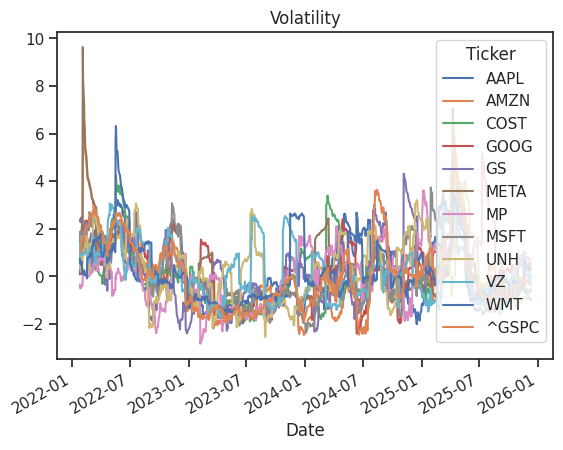

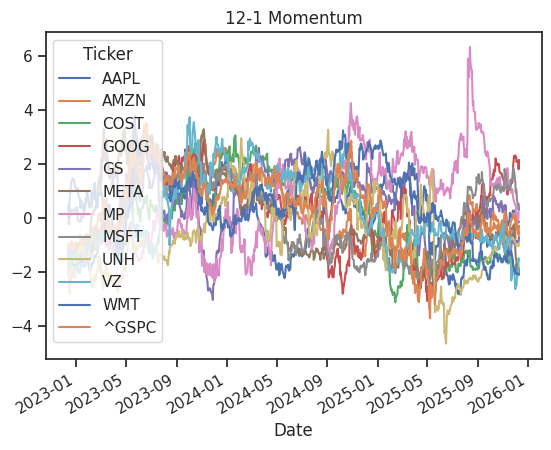

In [172]:
z_volatility_price_data.plot(title = "Volatility")
z_returns_price_data_12_1.plot(title = "12-1 Momentum")

#### Combine and Rank Factors

In [173]:
cz_returns_price_data_12_1 = cross_standardize(z_returns_price_data_12_1)
cz_volatility_price_data = cross_standardize(z_volatility_price_data)
cz_combined = cz_returns_price_data_12_1.add(cz_volatility_price_data).dropna()
display(cz_combined.tail())
print(cz_combined.shape)

Ticker,AAPL,AMZN,COST,GOOG,GS,META,MP,MSFT,UNH,VZ,WMT,^GSPC
Date,,,,,,,,,,,,
2025-12-04,-1.222194,1.901517,-1.908270,2.853987,-0.558467,0.353571,0.523302,1.204152,-1.561080,-0.886559,-0.427217,-0.272741
2025-12-05,-1.167496,1.925446,-1.916286,3.072258,-0.355574,0.390184,0.626884,1.105232,-1.519674,-1.548532,-0.424770,-0.187672
2025-12-08,-1.094683,1.707910,-1.885806,3.342339,-0.664905,0.146607,0.483527,1.177344,-1.373638,-1.306216,-0.302995,-0.229484
2025-12-09,-1.255393,1.616138,-1.999642,3.009418,-0.613959,0.053225,0.712874,1.040155,-1.417205,-0.309630,-0.469926,-0.366053
2025-12-10,-1.406525,1.579235,-1.898521,2.975654,-0.570165,0.155124,0.785185,0.928146,-1.415448,-0.408157,-0.479368,-0.245162


(751, 12)


### Portfolio

In [174]:
portfolio_weights = cvx_optimize_factor_portfolio(factor_scores = cz_combined.iloc[-1], covariance_matrix=price_data.pct_change().cov().values, expected_returns=price_data.pct_change().mean().values, risk_tolerance=.9, print_parameters=True, state = "Bull")
portfolio_weights.value = np.array(portfolio_weights.value).flatten()

np.set_printoptions(suppress=True, precision=8)
print("Optimized Portfolio: ")
df_portfolio_weights = pd.DataFrame(portfolio_weights.value, index = price_data.columns, columns = ['Weight'])
print(df_portfolio_weights)
np.set_printoptions(suppress=False)



Building Porfolio using: 

Factor Scores: 
 Ticker
AAPL    -1.406525
AMZN     1.579235
COST    -1.898521
GOOG     2.975654
GS      -0.570165
META     0.155124
MP       0.785185
MSFT     0.928146
UNH     -1.415448
VZ      -0.408157
WMT     -0.479368
^GSPC   -0.245162
Name: 2025-12-10 00:00:00, dtype: float64

Covariance Matrix: 
 [[3.12593614e-04 2.19422238e-04 1.17500926e-04 1.99118279e-04
  1.21206602e-04 2.35732774e-04 1.91154871e-04 1.81450408e-04
  4.74074494e-05 3.23182173e-05 6.68671222e-05 1.43057143e-04]
 [2.19422238e-04 4.90277915e-04 1.33816377e-04 2.67504623e-04
  1.55112771e-04 3.64223017e-04 2.72018830e-04 2.35330328e-04
  3.77925647e-05 1.46793346e-05 7.12769733e-05 1.69234451e-04]
 [1.17500926e-04 1.33816377e-04 2.00769737e-04 1.00107918e-04
  7.15927898e-05 1.40972977e-04 9.14835607e-05 1.08082469e-04
  4.96119781e-05 2.26378291e-05 1.03982910e-04 8.78309397e-05]
 [1.99118279e-04 2.67504623e-04 1.00107918e-04 3.78659749e-04
  1.26910223e-04 3.01289547e-04 2.27199052e-04

### Backtesting

## Results

This section below is generated with the help of LLMs (Gemini).

In [175]:
full_macro_data = pd.concat([macro_data, data_macro_portfolio])

display(full_macro_data.head())
display(full_macro_data.tail())

,SP500,^GSPC
Date,,
2020-12-11,3663.459961,NaN
2020-12-14,3647.489990,NaN
2020-12-15,3694.620117,NaN
2020-12-16,3701.169922,NaN
2020-12-17,3722.479980,NaN


,SP500,^GSPC
Date,,
2025-12-04,NaN,6857.120117
2025-12-05,NaN,6870.399902
2025-12-08,NaN,6846.509766
2025-12-09,NaN,6840.509766
2025-12-10,NaN,6886.680176


In [176]:
data_macro_portfolio.columns = ['SP500']
full_macro_data = pd.concat([macro_data, data_macro_portfolio])

display(full_macro_data.head())
display(full_macro_data.tail())

,SP500
Date,
2020-12-11,3663.459961
2020-12-14,3647.489990
2020-12-15,3694.620117
2020-12-16,3701.169922
2020-12-17,3722.479980


,SP500
Date,
2025-12-04,6857.120117
2025-12-05,6870.399902
2025-12-08,6846.509766
2025-12-09,6840.509766
2025-12-10,6886.680176


In [177]:
rebalancing_dates = pd.date_range(start=start_date_portfolio, end=end_date_portfolio, freq='M')

print("Rebalancing Dates:")
display(rebalancing_dates)


Rebalancing Dates:


DatetimeIndex(['2024-12-31 03:01:09.891208', '2025-01-31 03:01:09.891208',
               '2025-02-28 03:01:09.891208', '2025-03-31 03:01:09.891208',
               '2025-04-30 03:01:09.891208', '2025-05-31 03:01:09.891208',
               '2025-06-30 03:01:09.891208', '2025-07-31 03:01:09.891208',
               '2025-08-31 03:01:09.891208', '2025-09-30 03:01:09.891208',
               '2025-10-31 03:01:09.891208', '2025-11-30 03:01:09.891208'],
              dtype='datetime64[ns]', freq='ME')

Create a Pandas Series `portfolio_returns_series` from the `portfolio_daily_returns` and `portfolio_return_dates` variables. Then, calculate the cumulative returns of this series. For the S&P 500 benchmark, slice `full_macro_data` using `start_date_portfolio.normalize()` and `end_date_portfolio.normalize()` to extract the relevant S&P 500 prices, calculate its daily returns, and then its cumulative returns. Finally, combine both portfolio and S&P 500 cumulative returns into a single DataFrame, rebase them to 1 at the start of the backtesting period, and plot them for comparison.

In [178]:
portfolio_daily_returns = []
portfolio_return_dates = []
rebalanced_weights_df = pd.DataFrame(columns=tickers)

# Initialize with equal weights for the first rebalancing period
initial_weight = 1 / len(tickers)
last_valid_weights = np.array([initial_weight] * len(tickers))

for i, rebalance_date in enumerate(rebalancing_dates):
    #print(f"Processing rebalance date: {rebalance_date.strftime('%Y-%m-%d')}")

    # Determine the next rebalance date for slicing the period_price_data
    if i + 1 < len(rebalancing_dates):
        next_rebalance_date = rebalancing_dates[i + 1]
    else:
        # Ensure the last period goes up to and includes end_date_portfolio
        next_rebalance_date = end_date_portfolio.normalize() + pd.Timedelta(days=1)

    # Slice data up to the current rebalance date for factor calculation and regime detection
    current_price_data = price_data.loc[start_date:rebalance_date.normalize()]
    current_macro_data = full_macro_data.loc[start_date:rebalance_date.normalize()]

    # Calculate S&P 500 returns for regime detection
    current_sp500_returns = np.log(current_macro_data['SP500'] / current_macro_data['SP500'].shift(1)).dropna()

    # Check for data sufficiency for factor calculation (at least 252 trading days for 1-year window)
    if len(current_price_data) < 252 or current_sp500_returns.empty:
        print(f"Skipping {rebalance_date}: Insufficient data for factor calculation or regime detection.")
        current_weights = last_valid_weights
    else:
        # Determine market regime for the current period
        hmm_groups_current = hmm_model.predict(current_sp500_returns.values.reshape(-1, 1))
        current_regime_index = hmm_groups_current[-1] # Get the regime for the latest day

        # Map the regime index to the state (Bear, Neutral, Bull)
        # sorted_means_indices_hmm gives mapping from sorted mean to original index.
        # We need to find which original index corresponds to our state. Example: if hmm_groups_current[-1] = 0,
        # and sorted_means_indices_hmm = [2, 1, 0], then 0 is the Bull state.

        # Find the position of current_regime_index in sorted_means_indices_hmm
        regime_state_idx = np.where(sorted_means_indices_hmm == current_regime_index)[0][0]
        current_market_state = state_space[regime_state_idx]

        print(f"Market regime for {rebalance_date.strftime('%Y-%m-%d')}: {current_market_state}")

        # Calculate Momentum Factor (12-1 month return)
        momentum_12_1_factor = momentum_12_1(current_price_data)
        z_momentum_12_1_factor = standardize_factor_data(momentum_12_1_factor, window_size=252)
        cz_momentum_12_1_factor = cross_standardize(z_momentum_12_1_factor)

        # Calculate Volatility Factor (30-day rolling standard deviation of daily returns)
        volatility_factor = current_price_data.pct_change().rolling(window=30).std()
        z_volatility_factor = standardize_factor_data(volatility_factor, window_size=252)
        cz_volatility_factor = cross_standardize(z_volatility_factor)

        # Combine factors
        combined_factors = cz_momentum_12_1_factor.add(cz_volatility_factor, fill_value=0).dropna()

        if combined_factors.empty:
            print(f"Skipping {rebalance_date}: Combined factors DataFrame is empty. Using last valid weights.")
            current_weights = last_valid_weights
        else:
            # Prepare inputs for optimization
            # Use the last available factor scores
            factor_scores_latest = combined_factors.iloc[-1]

            # Calculate covariance matrix and expected returns from current_price_data
            # Only consider the period used for factor calculation to avoid look-ahead bias.
            daily_returns_current = current_price_data.pct_change().dropna()
            covariance_matrix = daily_returns_current.cov().values
            expected_returns = daily_returns_current.mean().values

            try:
                # Optimize portfolio weights
                optimized_weights_obj = cvx_optimize_factor_portfolio(
                    factor_scores=factor_scores_latest,
                    covariance_matrix=covariance_matrix,
                    expected_returns=expected_returns,
                    risk_tolerance=0.5,
                    state=current_market_state
                )
                current_weights = np.array(optimized_weights_obj.value).flatten()
                # Ensure weights are non-negative and sum to 1 (due to solver tolerances, sometimes values are slightly negative or sum not exactly 1)
                current_weights[current_weights < 0] = 0
                current_weights = current_weights / np.sum(current_weights)

            except Exception as e:
                print(f"Optimization failed for {rebalance_date}: {e}. Using last valid weights.")
                current_weights = last_valid_weights

    # Update last_valid_weights for the next iteration
    last_valid_weights = current_weights

    # Store weights
    weights_series = pd.Series(last_valid_weights, index=tickers, name=rebalance_date)
    rebalanced_weights_df = pd.concat([rebalanced_weights_df, pd.DataFrame([weights_series])])

    # Calculate daily returns for the next period using the newly optimized weights
    period_price_data = price_data.loc[rebalance_date.normalize() + pd.Timedelta(days=1):next_rebalance_date.normalize()]

    if not period_price_data.empty:
        period_returns = period_price_data.pct_change().dropna()
        if not period_returns.empty:
            period_portfolio_returns = (period_returns * last_valid_weights).sum(axis=1)
            portfolio_daily_returns.extend(period_portfolio_returns.tolist())
            portfolio_return_dates.extend(period_portfolio_returns.index.tolist())


print("Monthly rebalancing strategy executed.")
print(f"Number of daily returns calculated: {len(portfolio_daily_returns)}")
print("Rebalanced weights DataFrame:")
display(rebalanced_weights_df)

# Create a Pandas Series named portfolio_returns_series
portfolio_returns_series = pd.Series(portfolio_daily_returns, index=portfolio_return_dates)
portfolio_returns_series = portfolio_returns_series.loc[~portfolio_returns_series.index.duplicated(keep='first')]

# Calculate the cumulative returns of portfolio_returns_series
portfolio_cumulative_returns = (1 + portfolio_returns_series).cumprod()

# Slice the full_macro_data DataFrame to extract the S&P 500 prices
sp500_prices = full_macro_data.loc[start_date_portfolio.normalize():end_date_portfolio.normalize()]

# Calculate the daily returns of sp500_prices
sp500_returns = sp500_prices.pct_change().dropna()

# Calculate the cumulative returns of sp500_returns
sp500_cumulative_returns = (1 + sp500_returns).cumprod()

# Combine portfolio_cumulative_returns and sp500_cumulative_returns
combined_cumulative_returns = pd.DataFrame({
    'Portfolio': portfolio_cumulative_returns,
    'S&P 500': sp500_cumulative_returns.iloc[:, 0] # Take the first column if multiple present
}).dropna()

# Rebase combined_cumulative_returns to start at 1
initial_value = combined_cumulative_returns.iloc[0]
combined_cumulative_returns_rebased = combined_cumulative_returns / initial_value


Market regime for 2024-12-31: Neutral
Market regime for 2025-01-31: Neutral
Market regime for 2025-02-28: Neutral
Market regime for 2025-03-31: Neutral
Market regime for 2025-04-30: Bear
Market regime for 2025-05-31: Neutral
Market regime for 2025-06-30: Neutral
Market regime for 2025-07-31: Neutral
Market regime for 2025-08-31: Neutral
Market regime for 2025-09-30: Neutral
Market regime for 2025-10-31: Neutral
Market regime for 2025-11-30: Neutral
Monthly rebalancing strategy executed.
Number of daily returns calculated: 224
Rebalanced weights DataFrame:


,AAPL,MSFT,GOOG,AMZN,META,^GSPC,GS,MP,VZ,WMT,COST,UNH
2024-12-31 03:01:09.891208,0.000000e+00,0.000000e+00,0.000000e+00,1.339711e-22,5.902638e-01,3.535792e-23,2.310329e-23,6.144962e-23,7.208929e-23,1.710851e-23,4.097362e-01,4.800225e-23
2025-01-31 03:01:09.891208,5.298833e-22,2.953496e-22,2.048741e-22,2.453742e-22,9.740166e-01,2.598342e-02,2.126000e-22,2.099399e-22,2.681236e-22,2.691446e-22,1.168428e-22,2.514826e-22
2025-02-28 03:01:09.891208,1.238025e-22,2.245343e-25,0.000000e+00,0.000000e+00,6.069183e-01,2.781547e-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.930817e-01,0.000000e+00
2025-03-31 03:01:09.891208,0.000000e+00,0.000000e+00,8.127999e-01,1.379568e-23,1.872001e-01,9.990771e-23,0.000000e+00,2.126193e-23,7.011819e-23,0.000000e+00,0.000000e+00,0.000000e+00
2025-04-30 03:01:09.891208,1.468971e-01,3.105082e-23,2.585280e-01,0.000000e+00,4.227202e-01,1.133308e-01,5.852393e-02,5.333343e-23,0.000000e+00,1.126193e-22,0.000000e+00,3.839820e-23
2025-05-31 03:01:09.891208,1.976861e-22,1.393563e-22,6.211621e-01,2.243752e-22,1.552200e-01,2.236179e-01,1.739480e-22,6.724978e-23,3.938953e-23,1.559320e-22,0.000000e+00,1.000092e-22
2025-06-30 03:01:09.891208,1.121527e-22,0.000000e+00,1.767034e-22,6.268351e-23,5.298767e-01,2.016300e-01,2.684933e-01,1.269606e-22,3.504979e-23,1.503094e-22,2.420058e-22,7.146102e-23
2025-07-31 03:01:09.891208,5.518459e-23,0.000000e+00,6.821610e-23,2.447509e-23,6.610835e-02,3.624197e-01,5.714719e-01,0.000000e+00,1.312209e-22,1.253516e-22,1.100534e-22,8.245020e-23
2025-08-31 03:01:09.891208,5.668259e-23,0.000000e+00,6.214166e-23,1.344610e-22,1.382288e-01,4.331000e-01,4.286712e-01,2.590691e-23,4.019122e-23,4.077491e-23,4.005786e-23,8.819283e-23
2025-09-30 03:01:09.891208,0.000000e+00,0.000000e+00,0.000000e+00,5.834268e-01,5.224777e-02,0.000000e+00,3.643255e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


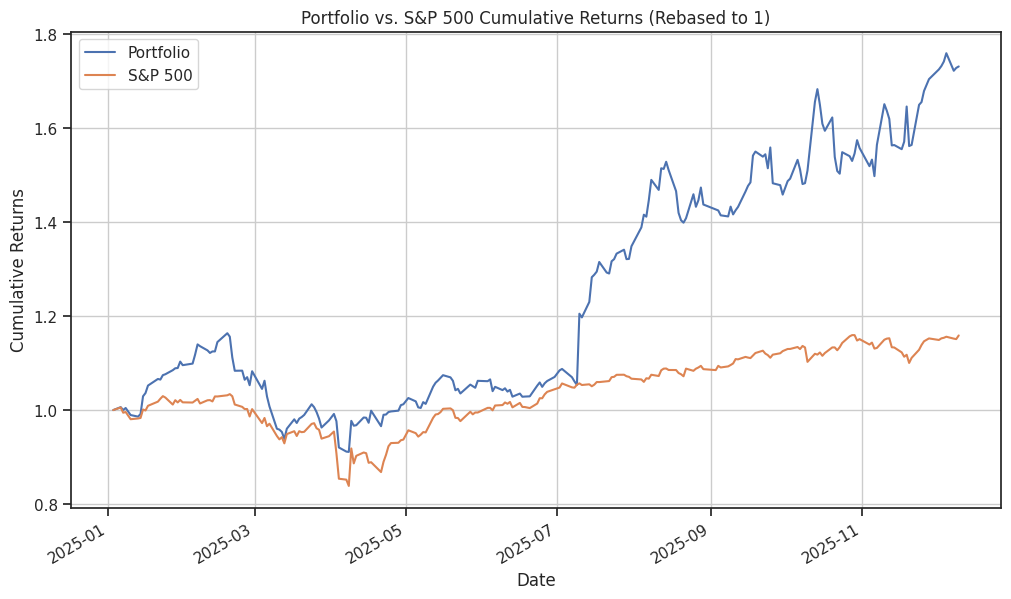

In [179]:
# Plot the rebased combined_cumulative_returns
plt.figure(figsize=(12, 7))
combined_cumulative_returns_rebased.plot(ax=plt.gca())
plt.title('Portfolio vs. S&P 500 Cumulative Returns (Rebased to 1)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()